Epoch 1, Loss: 247.0637
Epoch 2, Loss: 154.7257
Epoch 3, Loss: 115.6207
Epoch 4, Loss: 103.5345
Epoch 5, Loss: 99.0902
Epoch 6, Loss: 97.2670
Epoch 7, Loss: 95.8787
Epoch 8, Loss: 95.1572
Epoch 9, Loss: 94.2373
Epoch 10, Loss: 93.1575
Epoch 11, Loss: 92.4617
Epoch 12, Loss: 91.9680
Epoch 13, Loss: 91.3752
Epoch 14, Loss: 90.4795
Epoch 15, Loss: 89.7602
Epoch 16, Loss: 89.4878
Epoch 17, Loss: 88.5599
Epoch 18, Loss: 87.9463
Epoch 19, Loss: 86.9733
Epoch 20, Loss: 86.5345


[W NNPACK.cpp:64] Could not initialize NNPACK! Reason: Unsupported hardware.


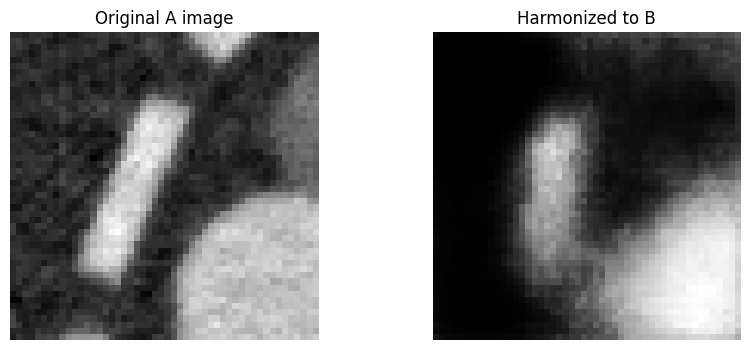

In [ ]:
# %% [markdown]
# # 🔄 VAE-Based Harmonization of Algorithm A → B Images
# This notebook trains a Conditional Variational Autoencoder (cVAE) to transform reconstructed images from Algorithm A to Algorithm B.

# %% 
# ✅ Imports
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split

# %% 
# ✅ Load datasets
A = np.load("../../data/augmented_images_algoA.npy")
B = np.load("../../data/augmented_images_algoB.npy")

# Combine and create labels
X = np.concatenate([A, B], axis=0)  # shape (N, 50, 50)
y = np.concatenate([np.zeros(len(A)), np.ones(len(B))])  # 0 = A, 1 = B

# Reshape for PyTorch
X = X[:, None, :, :]  # shape (N, 1, 50, 50)
X = torch.tensor(X, dtype=torch.float32)
y = torch.tensor(y, dtype=torch.float32)

# Train/test split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
train_ds = TensorDataset(X_train, y_train)
val_ds = TensorDataset(X_val, y_val)
train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=32)

# %% 
# ✅ Define Conditional VAE
class CVAE(nn.Module):
    def __init__(self, latent_dim=16):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(2, 32, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(32, 64, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
        )
        self.fc_mu = nn.Linear(64 * 12 * 12, latent_dim)
        self.fc_logvar = nn.Linear(64 * 12 * 12, latent_dim)

        self.decoder_fc = nn.Linear(latent_dim + 1, 64 * 12 * 12)
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, 4, stride=2, padding=1), nn.ReLU(),
            nn.ConvTranspose2d(32, 1, 4, stride=2, padding=1), nn.Sigmoid(),
            nn.Upsample(size=(50, 50), mode='bilinear', align_corners=False)
)


    def encode(self, x, label):
        label = label.view(-1, 1, 1, 1).expand(-1, 1, x.size(2), x.size(3))
        x_cond = torch.cat([x, label], dim=1)
        h = self.encoder(x_cond).view(x.size(0), -1)
        return self.fc_mu(h), self.fc_logvar(h)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z, label):
        z = torch.cat([z, label.unsqueeze(1)], dim=1)
        h = self.decoder_fc(z).view(-1, 64, 12, 12)
        return self.decoder(h)

    def forward(self, x, label):
        mu, logvar = self.encode(x, label)
        z = self.reparameterize(mu, logvar)
        recon = self.decode(z, label)
        return recon, mu, logvar

# %% 
# ✅ Loss function
def vae_loss(recon_x, x, mu, logvar):
    recon_loss = F.mse_loss(recon_x, x, reduction='sum')
    kl = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return recon_loss + kl

# %% 
# ✅ Training loop
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CVAE().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

epochs = 20
for epoch in range(epochs):
    model.train()
    train_loss = 0
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        recon, mu, logvar = model(xb, yb)
        loss = vae_loss(recon, xb, mu, logvar)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    print(f"Epoch {epoch+1}, Loss: {train_loss / len(train_loader.dataset):.4f}")

# %% 
# ✅ Inference: Harmonize A → B
model.eval()
sample_idx = np.random.randint(0, len(A))
sample = torch.tensor(A[sample_idx:sample_idx+1], dtype=torch.float32).to(device)
sample = sample.unsqueeze(1)  # (1, 1, 50, 50)
label_A = torch.tensor([0.0], device=device)
label_B = torch.tensor([1.0], device=device)

with torch.no_grad():
    mu, logvar = model.encode(sample, label_A)
    z = model.reparameterize(mu, logvar)
    harmonized = model.decode(z, label_B).squeeze().cpu().numpy()

# %% 
# ✅ Visualize
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.imshow(sample.squeeze().cpu().numpy(), cmap='gray')
plt.title('Original A image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(harmonized, cmap='gray')
plt.title('Harmonized to B')
plt.axis('off')
plt.show()

torch.save(model.state_dict(), "cvae_harmonization.pth")


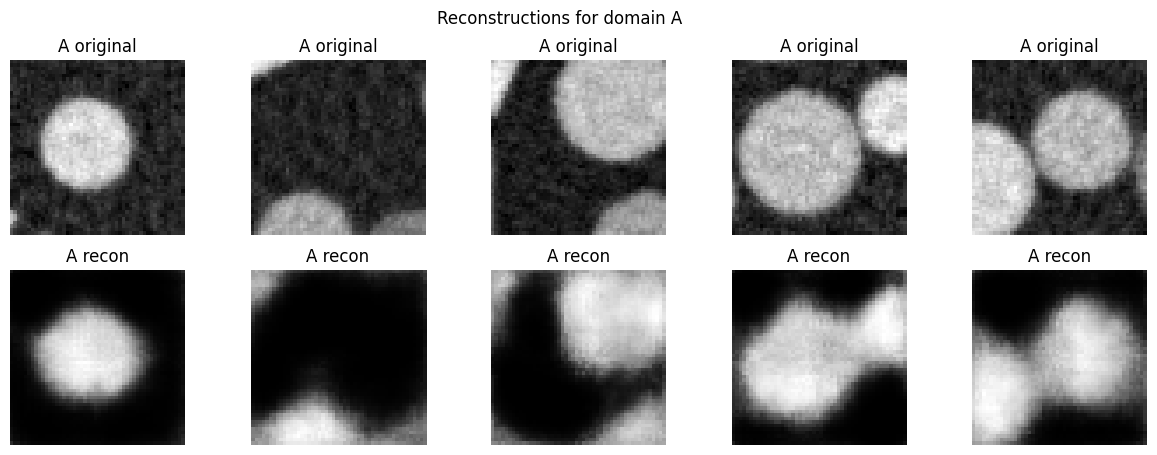

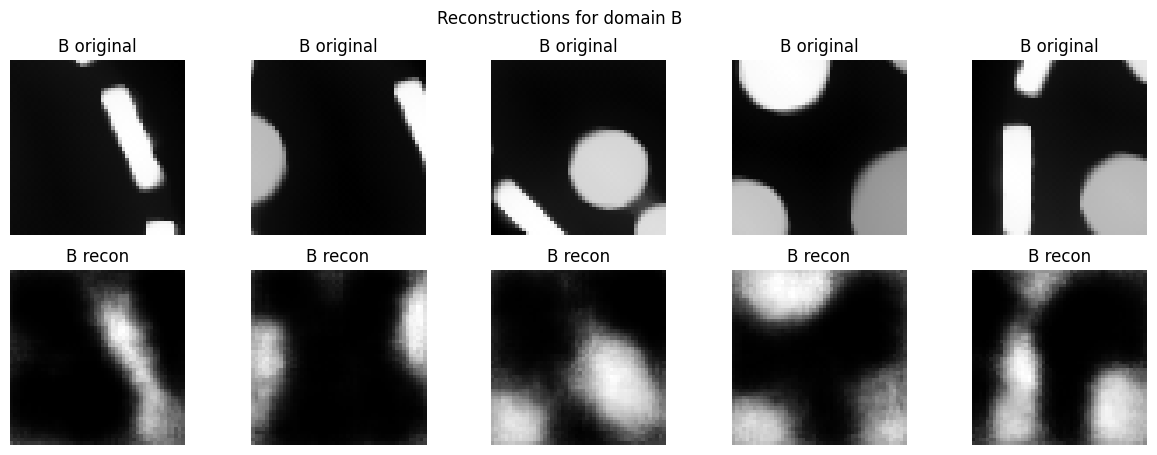

In [8]:

# ✅ Visualize some reconstructions from A and B
# Encode batch of A
X_A = torch.tensor(A[:, None, :, :], dtype=torch.float32).to(device)
labels_A = torch.zeros(len(A), device=device)

with torch.no_grad():
    mu_A, _ = model.encode(X_A, labels_A)
    z_A = mu_A.cpu().numpy()

# Encode batch of B
X_B = torch.tensor(B[:, None, :, :], dtype=torch.float32).to(device)
labels_B = torch.ones(len(B), device=device)

with torch.no_grad():
    mu_B, _ = model.encode(X_B, labels_B)
    z_B = mu_B.cpu().numpy()

N_vis = 5
X_vis_A = X_A[:N_vis]
X_vis_B = X_B[:N_vis]
labels_vis_A = torch.zeros(len(X_vis_A), device=device)
labels_vis_B = torch.ones(len(X_vis_B), device=device)

# Reconstructions
with torch.no_grad():
    recon_A, _, _ = model(X_vis_A, labels_vis_A)
    recon_B, _, _ = model(X_vis_B, labels_vis_B)

# Plot
fig, axes = plt.subplots(2, N_vis, figsize=(15, 5))

for i in range(N_vis):
    axes[0, i].imshow(X_vis_A[i,0].cpu().numpy(), cmap='gray')
    axes[0, i].set_title("A original")
    axes[0, i].axis('off')

    axes[1, i].imshow(recon_A[i,0].cpu().numpy(), cmap='gray')
    axes[1, i].set_title("A recon")
    axes[1, i].axis('off')

plt.suptitle("Reconstructions for domain A")
plt.show()

# Same for B
fig, axes = plt.subplots(2, N_vis, figsize=(15, 5))

for i in range(N_vis):
    axes[0, i].imshow(X_vis_B[i,0].cpu().numpy(), cmap='gray')
    axes[0, i].set_title("B original")
    axes[0, i].axis('off')

    axes[1, i].imshow(recon_B[i,0].cpu().numpy(), cmap='gray')
    axes[1, i].set_title("B recon")
    axes[1, i].axis('off')

plt.suptitle("Reconstructions for domain B")
plt.show()
